# Draft for Model + PCA (Smoothie King)

RandomForestClassifier
RandomForestClassifier + PCA
Hierarchical Clustering
Hierarchical Clustering + PCA

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

In [3]:
DIR = "../../data/"
SMOOTHIE = "Smoothie King/smoothie_king_"

In [4]:
smoothie_demographic = pd.read_csv(DIR + SMOOTHIE + "demographic_variables.csv")
smoothie_stores = pd.read_csv(DIR + SMOOTHIE + "stores.csv")
smoothie_poi_variables = pd.read_csv(DIR + SMOOTHIE + "poi_variables.csv")

In [5]:
smoothie_merged = smoothie_stores.merge(smoothie_demographic).merge(smoothie_poi_variables)
smoothie_merged.to_csv(DIR + SMOOTHIE + "merged.csv")

In [6]:
train_df, test_df = train_test_split(smoothie_merged, test_size=0.1, random_state=42)
X_train = train_df.drop(columns=["category"])
y_train = train_df["category"]
X_test = test_df.drop(columns=["category"])
y_test = test_df["category"]

In [7]:
drop_features = ["store", "longitude", "latitude"]
ordinal_features_oth = [
    "market_size",
    "store_density",
]
ordering_ordinal_oth = [
    ["Very Large Metro (1)", "Large Metro (2)", "Large City (3)", "Medium City (4)", "Small City (5)", "Small Town (6)"],
    ["Rural", "Exurban", "Suburban", "Light Suburban", "Light Urban", "Urban", "Super Urban"],
]
categorical_features = ["cbsa_name", "dma_name", "state_name"]

numeric_features = list(set(smoothie_merged.select_dtypes(include=np.number).columns.tolist()) - {"longitude", "latitude"})

In [8]:
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"), 
    StandardScaler()
)

ordinal_transformer_oth = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_oth),
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer_oth, ordinal_features_oth),
    (categorical_transformer, categorical_features),
)

In [9]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('drop', 'drop',
                                 ['store', 'longitude', 'latitude']),
                                ('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['edu_bachplus_female_p_2mi', 'edu_bach_2mi',
                                  'age0018_1mi', 'hh_type_male_nochild_p_1mi',
                                  'black_10mi', 'avg_faminc_5mi',
                                  'hh_type_female_nochild_3mi',
                                  'emp...
                                                                              'Town '
                                                                              '(6)'],
                                                                             ['Rural',
                                                                              'Exurban',
                                                                              'Suburban',
                                                                              'Light '
                                                                              'Suburban',
                                                                              'Light '
                                                                              'Urban',
                                                                              'Urban',
                                                                              'Super '
                                                                              'Urban']]))]),
                                 ['market_size', 'store_density']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['cbsa_name', 'dma_name', 'state_name'])])

In [10]:
column_names = (
    numeric_features
    + preprocessor.named_transformers_['pipeline-2']['ordinalencoder'].get_feature_names_out().tolist()
    + preprocessor.named_transformers_['pipeline-3']['onehotencoder'].get_feature_names_out().tolist()
)
len(column_names)

1415

In [11]:
preprocessor.named_transformers_['pipeline-3']['onehotencoder']

OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False)

In [12]:
transformed_X = preprocessor.transform(X_train)
# X_test_processed = preprocessor.transform(X_test)

In [13]:
transformed_X_df = pd.DataFrame(transformed_X, columns=column_names)
transformed_X_df

,edu_bachplus_female_p_2mi,edu_bach_2mi,age0018_1mi,hh_type_male_nochild_p_1mi,black_10mi,avg_faminc_5mi,hh_type_female_nochild_3mi,emp_other_p_10mi,dtpop_homemakers_p_2mi,edu_doctorate_3mi,...,x2_North Carolina,x2_Ohio,x2_Oklahoma,x2_Pennsylvania,x2_South Carolina,x2_Tennessee,x2_Texas,x2_Virginia,x2_West Virginia,x2_Wisconsin
0,1.068699,-0.087869,-0.423713,-1.152928,-0.500147,1.384594,-0.556547,-0.769315,1.649654,0.106313,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.004578,1.084022,0.350065,0.599380,2.320485,0.793014,0.489041,-0.322498,-1.150830,0.550082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.818895,0.418355,-0.181367,-1.293113,0.088561,1.451162,-0.410807,0.045470,1.469492,-0.031586,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-1.394614,-0.420115,0.492876,1.867415,-0.488401,-0.157640,0.041275,0.273259,-0.149680,-0.461418,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.332644,-0.041768,-0.543588,-0.235356,-0.758314,1.807571,-0.269382,-0.760554,-0.687884,-0.312517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,1.864868,1.941285,0.797541,-0.796095,1.320452,0.304065,0.209547,0.536093,-1.593252,0.331498,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
712,1.122133,-0.194017,-0.639661,-0.917163,0.012414,-0.423316,-0.360948,1.035477,0.014518,-0.279510,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
713,-0.821533,-0.189760,0.376464,0.038642,-0.505961,1.171842,-0.256438,-0.278692,0.094336,-0.388801,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
714,0.764125,-0.207965,-0.164922,-0.222612,0.334582,-1.194295,0.169276,0.141842,-1.041365,-0.318385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
n_components = 63
pca = PCA(n_components=n_components, whiten=True, random_state=0)
pca.fit(transformed_X)

PCA(n_components=63, random_state=0, whiten=True)

In [15]:
df = pd.DataFrame(
    data=np.cumsum(pca.explained_variance_ratio_),
    columns=["cummulative variance_explained (%)"],
    index=range(1, n_components + 1),
)
df.index.name = "n_components"

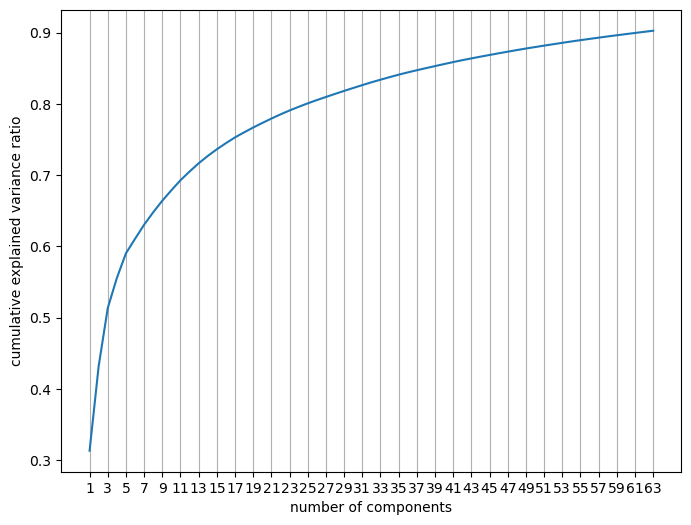

In [16]:
plt.figure(figsize=(8, 6))
plt.xticks(range(1, 64, 2))
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance ratio")
plt.plot(range(1, 64), np.cumsum(pca.explained_variance_ratio_))
plt.grid(axis = 'x')
plt.show()

In [17]:
feature_names_out = pca.get_feature_names_out(column_names)
feature_names_out

array(['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7',
       'pca8', 'pca9', 'pca10', 'pca11', 'pca12', 'pca13', 'pca14',
       'pca15', 'pca16', 'pca17', 'pca18', 'pca19', 'pca20', 'pca21',
       'pca22', 'pca23', 'pca24', 'pca25', 'pca26', 'pca27', 'pca28',
       'pca29', 'pca30', 'pca31', 'pca32', 'pca33', 'pca34', 'pca35',
       'pca36', 'pca37', 'pca38', 'pca39', 'pca40', 'pca41', 'pca42',
       'pca43', 'pca44', 'pca45', 'pca46', 'pca47', 'pca48', 'pca49',
       'pca50', 'pca51', 'pca52', 'pca53', 'pca54', 'pca55', 'pca56',
       'pca57', 'pca58', 'pca59', 'pca60', 'pca61', 'pca62'], dtype=object)

In [18]:
transformed_features = pd.DataFrame(abs(pca.components_), columns=column_names, index=feature_names_out)
transformed_features.head()

,edu_bachplus_female_p_2mi,edu_bach_2mi,age0018_1mi,hh_type_male_nochild_p_1mi,black_10mi,avg_faminc_5mi,hh_type_female_nochild_3mi,emp_other_p_10mi,dtpop_homemakers_p_2mi,edu_doctorate_3mi,...,x2_North Carolina,x2_Ohio,x2_Oklahoma,x2_Pennsylvania,x2_South Carolina,x2_Tennessee,x2_Texas,x2_Virginia,x2_West Virginia,x2_Wisconsin
pca0,0.016604,0.050480,0.047897,0.000193,0.040189,0.010851,0.045414,0.010989,0.012779,0.043871,...,0.000585,0.000220,0.000023,0.000013,0.000604,0.000924,0.003609,0.000255,0.000009,0.000013
pca1,0.053612,0.010950,0.005265,0.026437,0.006541,0.076009,0.023308,0.014670,0.014996,0.005947,...,0.000899,0.000390,0.000148,0.000650,0.000186,0.000011,0.008225,0.000801,0.000141,0.000104
pca2,0.059222,0.007324,0.011672,0.040246,0.005068,0.029063,0.030494,0.003891,0.054908,0.032649,...,0.001573,0.001694,0.000084,0.000730,0.000528,0.001713,0.013356,0.000543,0.000278,0.000284
pca3,0.016969,0.011656,0.023672,0.004609,0.009839,0.006014,0.010668,0.004380,0.061927,0.032442,...,0.001449,0.001955,0.000113,0.001557,0.000003,0.000180,0.015923,0.001197,0.000644,0.000040
pca4,0.011708,0.027504,0.019079,0.014677,0.025761,0.012174,0.029730,0.031117,0.036322,0.019117,...,0.000953,0.001009,0.000390,0.001460,0.001505,0.001006,0.023621,0.000267,0.000323,0.000067


### Try 1: Filter and Count Important Features (of heavy weights)

Filter the values in the PCA component matrix, and count the occurrence of the features in the filtered matrix.

In [19]:
pca0_df = transformed_features.iloc[0].sort_values(axis=0, ascending=True)
pca0_df.filter(pca0_df > 0.01)

Series([], Name: pca0, dtype: float64)

In [20]:
W = abs(pca.components_)
features = transformed_features.columns
long_results = []
for i in range(W.shape[0]):
    array = W[i]
    heavy_idx = np.where(array > 0.01)
    long_results += list(features[heavy_idx])

In [21]:
count = pd.Series(long_results).value_counts()
count[:20]

emp_finance_insurance_p_1mi          58
emp_retail_trade_p_2mi               58
hh_5vehicle_p_3mi                    57
hh_5vehicle_p_2mi                    57
emp_finance_insurance_p_2mi          56
emp_accommodation_foodserv_p_5mi     56
pop_seasonal_1mi                     56
emp_arts_entertainment_p_10mi        56
emp_finance_insurance_p_3mi          56
hh_4vehicle_p_2mi                    56
pop_seasonal_2mi                     56
hh_4vehicle_p_3mi                    55
military_installations_3mi           55
emp_information_p_10mi               55
emp_construction_p_2mi               55
hrsa_number_of_certified_beds_2mi    54
emp_construction_p_1mi               54
emp_arts_entertainment_p_3mi         54
emp_realestate_rentlease_p_2mi       54
emp_arts_entertainment_p_5mi         54
dtype: int64

## Hierachical Clustering

In [23]:
from scipy.cluster.hierarchy import (
    average,
    complete,
    dendrogram,
    fcluster,
    single,
    ward,
)

In [35]:
linkage_array = complete(transformed_X)
hier_labels = fcluster(linkage_array, 5, criterion="maxclust") 
# plot_dendrogram_clusters(X, linkage_array, hier_labels, linkage_type='complete', title="maxclust 3")

## PCA + Hierarchical Clustering

In [36]:
from scipy.cluster.hierarchy import (
    average,
    complete,
    dendrogram,
    fcluster,
    single,
    ward,
)

X = pca.transform(transformed_X)

In [37]:
linkage_array = complete(X)
hier_labels = fcluster(linkage_array, 5, criterion="maxclust") 
# plot_dendrogram_clusters(X, linkage_array, hier_labels, linkage_type='complete', title="maxclust 3")

In [38]:
hier_labels

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [40]:
y_train

732        HOME
137       OTHER
72         HOME
77         WORK
645    SHOPPING
         ...   
71        OTHER
106        HOME
270    SHOPPING
435    SHOPPING
102        WORK
Name: category, Length: 716, dtype: object

## Random Forest Classifier

In [29]:
lr_pipe = make_pipeline(preprocessor, RandomForestClassifier(max_depth=50))
scores = cross_validate(lr_pipe, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.611269,0.012120,0.430556,1.0
1,0.585473,0.012176,0.510490,1.0
2,0.575473,0.011884,0.482517,1.0
3,0.595464,0.012144,0.461538,1.0
4,0.580956,0.012453,0.517483,1.0


In [30]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "randomforestclassifier__max_depth": range(5, 30),
}

random_search = RandomizedSearchCV(
    lr_pipe, param_distributions=param_grid, n_jobs=-1, n_iter=20, cv=5, random_state=42
)
random_search.fit(X_train, y_train)
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_randomforestclassifier__max_depth",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

/Users/xinrulu/miniconda3/envs/563/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/xinrulu/miniconda3/envs/563/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/xinrulu/miniconda3/envs/563/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/xinrulu/miniconda3/envs/563/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning:

rank_test_score,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
mean_test_score,0.49866,0.497232,0.495862,0.495833,0.495824,0.494464,0.493124,0.491657,0.490297,0.490258,0.488889,0.486111,0.486043,0.484703,0.483324,0.476311,0.474913,0.474893,0.467939,0.46655
param_randomforestclassifier__max_depth,13,5,17,16,27,22,8,21,20,9,28,7,23,14,29,25,26,6,10,18
mean_fit_time,0.808561,0.570613,0.769607,0.739901,0.752435,0.80931,0.701846,0.808366,0.804073,0.785065,0.808933,0.618542,0.789493,0.74538,0.74687,0.840379,0.807208,0.560628,0.698442,0.765545


## PCA + Random Forest Classifier

In [31]:
from sklearn.decomposition import PCA


lr_pca_pipe = make_pipeline(preprocessor, PCA(n_components=60, whiten=True, random_state=0), RandomForestClassifier(max_depth=20))
scores = cross_validate(lr_pca_pipe, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.364391,0.013111,0.500000,1.0
1,0.337406,0.013147,0.412587,1.0
2,0.332547,0.013312,0.468531,1.0
3,0.323127,0.012814,0.405594,1.0
4,0.338055,0.013658,0.475524,1.0


In [32]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "pca__n_components": range(10, 60),
    "randomforestclassifier__max_depth": range(12, 30),
}

print("Grid size: %d" % (np.prod(list(map(len, param_grid.values())))))
param_grid

Grid size: 900


{'pca__n_components': range(10, 60),
 'randomforestclassifier__max_depth': range(12, 30)}

In [33]:
random_search = RandomizedSearchCV(
    lr_pca_pipe, param_distributions=param_grid, n_jobs=-1, n_iter=20, cv=5, random_state=42
)
random_search.fit(X_train, y_train)

/Users/xinrulu/miniconda3/envs/563/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/xinrulu/miniconda3/envs/563/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/xinrulu/miniconda3/envs/563/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/xinrulu/miniconda3/envs/563/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning:

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['store',
                                                                                'longitude',
                                                                                'latitude']),
                                                                              ('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['edu_bachplus_female_p_2mi',
                                                                                'edu_bach_2mi',
                                                                                'age0018_1mi',
                                                                                'hh_type_male_nochild...
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['cbsa_name',
                                                                                'dma_name',
                                                                                'state_name'])])),
                                             ('pca',
                                              PCA(n_components=60,
                                                  random_state=0,
                                                  whiten=True)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(max_depth=20))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'pca__n_components': range(10, 60),
                                        'randomforestclassifier__max_depth': range(12, 30)},
                   random_state=42)

In [34]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_pca__n_components",
        "param_randomforestclassifier__max_depth",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,11,11,13,14,15,16,17,18,19,20
mean_test_score,0.494415,0.491618,0.488792,0.484615,0.483217,0.481818,0.48041,0.477632,0.477613,0.472038,0.467861,0.467861,0.466482,0.465093,0.460936,0.459431,0.458081,0.458032,0.453885,0.446921
param_pca__n_components,13,19,12,14,39,26,42,16,16,49,14,42,13,22,17,34,54,33,55,50
param_randomforestclassifier__max_depth,25,18,15,26,23,23,26,24,14,21,12,24,28,27,25,27,21,20,29,23
mean_fit_time,0.270459,0.341531,0.253197,0.261596,0.380755,0.331701,0.354892,0.299744,0.308977,0.396966,0.259258,0.345908,0.287997,0.284861,0.318551,0.372405,0.407943,0.410651,0.413592,0.391865
